In [58]:
import xarray as xr
import pandas as pd

In [59]:
ds = xr.open_dataset('pnwrain.50km.daily.4994.nc', decode_times=False)

In [60]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	float64 time(time) ;
		time:title = Time ;
		time:units = days    since 1949- 1- 1  0: 0: 0 ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

### Manually decode time variable since it fails when opening dataset

the extra spaces of the attribute unit string of the time variable is causing this issue

In [61]:
print(ds['time'])

<xarray.DataArray 'time' (time: 16801)>
array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 1.6798e+04, 1.6799e+04,
       1.6800e+04])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.68e+04 1.68e+04 1.68e+04
Attributes:
    title:    Time
    units:    days    since 1949- 1- 1  0: 0: 0


In [62]:
time_values = ds.time.values

Extract time values and units

In [63]:
time_values = ds.time.values

# Empty spaces in the unit string will cause issue on num2date function
# time_units = ds.time.attrs['units']

In [64]:
# Manually Parse the units string instead
reference_date = '1949-01-01 00:00:00'
time_units = 'days since ' + reference_date

Decode time values (assume Gregorian calendar )

In [65]:
from cftime import num2date

time_index = num2date(time_values, units=time_units)

In [66]:
# Create a Dataset with the time_index variable
time_ds = xr.Dataset({'time_index': ('time', time_index)})

# Merge the time_ds Dataset with the original dataset
ds = xr.merge([ds, time_ds], combine_attrs='override')

In [67]:
# Set 'time_index' as the new coordinate for 'time'
ds = ds.assign_coords({'time': ds['time_index']})

In [68]:
ds = ds.drop_vars('time_index')

In [69]:
ds['time'].attrs = {
    'title': 'Time',
    'units': 'days since 1949-01-01 00:00:00'
}

In [70]:
# Set time as the index
ds = ds.set_index(time='time')

In [71]:
# convert cftime.DatetimeGregorian to datetime
datetimeindex = ds.indexes['time'].to_datetimeindex()
ds['time'] = datetimeindex

In [72]:
ds.info()

xarray.Dataset {
dimensions:
	lat = 17 ;
	lon = 16 ;
	time = 16801 ;

variables:
	float32 lat(lat) ;
		lat:title = Latitude ;
		lat:units = degrees_north ;
	float32 lon(lon) ;
		lon:title = Longitude ;
		lon:units = degrees_east ;
	datetime64[ns] time(time) ;
	float32 data(time, lat, lon) ;
		data:long_name = mm/day ;
		data:units = mm/day ;

// global attributes:
}

Check gap in dates

In [73]:
# Calculate the differences between consecutive time points
time_diff = ds['time'].diff(dim='time')

# Convert time differences to a more interpretable format, like days
time_diff_in_days = time_diff / pd.to_timedelta(1, unit='D')

In [74]:
# more than 1 day is consider a gap
large_gap_threshold = 1  # days

# Find where the gaps exceed this threshold
large_gaps = time_diff_in_days.where(time_diff_in_days > large_gap_threshold, drop=True)

In [75]:
# Check if there are gaps
if len(large_gaps) > 0:
    print("Large gaps found at the following times:")
    print(large_gaps)
else:
    print("No large gaps found in the dates.")

No large gaps found in the dates.


Flatten data

In [76]:
# Stack 'lat' and 'lon' to create a single 'spatial' dimension
data_flat = ds['data'].stack(all_points=('time', 'lat', 'lon'))

In [77]:
data_flat

<xarray.DataArray 'data' (all_points: 4569872)>
array([nan, nan, nan, ..., 7.4, nan, nan], dtype=float32)
Coordinates:
  * all_points  (all_points) object MultiIndex
  * time        (all_points) datetime64[ns] 1949-01-01 1949-01-01 ... 1994-12-31
  * lat         (all_points) float32 49.76 49.76 49.76 ... 42.14 42.14 42.14
  * lon         (all_points) float32 -125.6 -125.0 -124.4 ... -116.9 -116.2
Attributes:
    long_name:  mm/day
    units:      mm/day

In [78]:
df_flat = data_flat.to_dataframe(name='precipitation').reset_index(drop=True)

In [79]:
print(df_flat.columns)

Index(['time', 'lat', 'lon', 'precipitation'], dtype='object')


In [80]:
df_flat.head(10)

,time,lat,lon,precipitation
0,1949-01-01,49.760941,-125.625,NaN
1,1949-01-01,49.760941,-125.000,NaN
2,1949-01-01,49.760941,-124.375,NaN
3,1949-01-01,49.760941,-123.750,NaN
4,1949-01-01,49.760941,-123.125,NaN
5,1949-01-01,49.760941,-122.500,NaN
6,1949-01-01,49.760941,-121.875,NaN
7,1949-01-01,49.760941,-121.250,NaN
8,1949-01-01,49.760941,-120.625,NaN
9,1949-01-01,49.760941,-120.000,NaN


Handle missing value in data

In [81]:
df_flat['precipitation'].fillna(0, inplace=True)

Check duplicated rows

In [82]:
# Check for any duplicate rows based on all columns
duplicate_rows = df_flat.duplicated()
print("Number of duplicate rows:", duplicate_rows.sum())

# To see the actual duplicate rows
if duplicate_rows.sum() > 0:
    print(df_flat[duplicate_rows])

Number of duplicate rows: 0


Feature engineering

In [83]:
df_flat['month'] = df_flat['time'].dt.month
df_flat['year'] = df_flat['time'].dt.year

In [84]:
df_flat.size

27419232

In [57]:
df_flat.head(10)

,time,lat,lon,precipitation,month,year
0,1949-01-01,49.760941,-125.625,0.0,1,1949
1,1949-01-01,49.760941,-125.000,0.0,1,1949
2,1949-01-01,49.760941,-124.375,0.0,1,1949
3,1949-01-01,49.760941,-123.750,0.0,1,1949
4,1949-01-01,49.760941,-123.125,0.0,1,1949
5,1949-01-01,49.760941,-122.500,0.0,1,1949
6,1949-01-01,49.760941,-121.875,0.0,1,1949
7,1949-01-01,49.760941,-121.250,0.0,1,1949
8,1949-01-01,49.760941,-120.625,0.0,1,1949
9,1949-01-01,49.760941,-120.000,0.0,1,1949


In [85]:
df_flat.to_csv('precipitation_data.csv', index=False)

In [62]:
non_zero_precipitation_count = df_flat[df_flat['precipitation'].notna() & (df_flat['precipitation'] != 0)].shape[0]

In [63]:
non_zero_precipitation_count

1329879

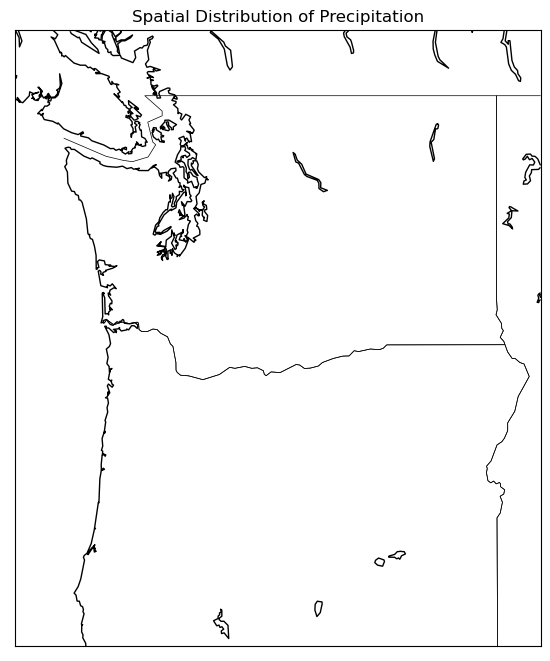

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define the boundaries of the map and resolution
fig, ax = plt.subplots(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=df_flat['lat'].min(), urcrnrlat=df_flat['lat'].max(),
            llcrnrlon=df_flat['lon'].min(), urcrnrlon=df_flat['lon'].max(), resolution='i')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Convert lat and lon to map projection coordinates
lons, lats = m(df_flat['lon'].values, df_flat['lat'].values)

# Scatter plot
# sc = m.scatter(lons, lats, c=df_flat['precipitation'], cmap='viridis', alpha=0.5)
# cbar = m.colorbar(sc, location='bottom', pad="10%")
# cbar.set_label('Precipitation (mm/day)')

plt.title('Spatial Distribution of Precipitation')
plt.show()

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df_flat' is your flattened DataFrame and 'precipitation' is the variable of interest
# Convert the DataFrame to a 2D numpy array (grid) structured as [lat, lon]
# The following is pseudocode and needs to be adjusted based on the actual structure of 'df_flat'

# Create a grid for lat and lon (you may need to adjust the resolution)
lon_values = np.unique(df_flat['lon'])
lat_values = np.unique(df_flat['lat'])
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)

# Create a corresponding grid for precipitation data
# This typically involves reshaping or pivoting the data
# An example using pandas pivot (this needs to be correctly specified)
precip_grid = df_flat.pivot(index='lat', columns='lon', values='precipitation').values

# Now plot the contour map with overlayed numerical values
plt.figure(figsize=(12, 9))

# Create a filled contour plot
contourf = plt.contourf(lon_grid, lat_grid, precip_grid, cmap='coolwarm', alpha=0.75)

# Add contour labels
contour = plt.contour(lon_grid, lat_grid, precip_grid, colors='black')
plt.clabel(contour, inline=True, fontsize=8)

# Add a color bar
plt.colorbar(contourf)

# Add titles and labels
plt.title('Total Precipitation Anomalies (cm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

ValueError: Index contains duplicate entries, cannot reshape